# 係り受け解析の結果を可視化

テキスト解析 Web API の日本語係り受け解析の結果を用いて、文節同士の関係がひと目でわかるようにしてみましょう。

本記事では、OSS である spaCy （ https://spacy.io/ ）や Graphviz （ https://graphviz.org/ ）の機能を使って、係り受け関係を視覚的に表示します。

## spaCy による可視化

### spaCy を導入する

spaCy の導入方法はバージョンや環境などによって異なる場合があります。
最新情報は spaCy の公式サイトをご参照ください。

In [1]:
! pip install -U pip setuptools wheel
! pip install -U spacy

### Python からリクエストする & spaCy で表示する

リクエストのコードは [サンプルコード](https://developer.yahoo.co.jp/webapi/jlp/sample/sample8.html)と同様のものです。

In [2]:
import json
from urllib import request

APPID = "あなたの Client ID（アプリケーション ID）"
URL = "https://jlp.yahooapis.jp/DAService/V2/parse"


def post(query: str) -> str:
    headers = {
        "Content-Type": "application/json",
        "User-Agent": "Yahoo AppID: {}".format(APPID),
    }
    param_dic = {
        "id": "1234-1",
        "jsonrpc": "2.0",
        "method": "jlp.daservice.parse",
        "params": {"q": query},
    }
    params = json.dumps(param_dic).encode()
    req = request.Request(URL, params, headers)
    with request.urlopen(req) as res:
        body = res.read()
    return body.decode()

（※）Client ID については[こちら](../02_API_Specifications/00_Overview.md#client-id%E3%82%A2%E3%83%97%E3%83%AA%E3%82%B1%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3id)をご覧ください。

In [3]:
import spacy
from spacy import displacy

def visualize_displacy(response_body: str, render_options: dict = {}):
    """
    日本語係り受け解析のレスポンスを使ってグラフを表示
    """
    response_json = json.loads(response_body)
    chunks = response_json["result"]["chunks"]
    token_separator = '/' # 単語の区切り記号
    words, arcs = [], []
    
    for chunk in chunks:
        chunk_text = token_separator.join([token[0] for token in chunk["tokens"]])
        words.append({"text": chunk_text, "tag": ""})
        # 係り受け先がある場合は矢印を追加
        if chunk["head"] != -1:
            arcs.append({"start": chunk["id"], "end": chunk["head"], "label": "", "dir": "right"})
    displacy.render({"words": words, "arcs": arcs}, style="dep", jupyter=True, manual=True, options=render_options)

### 実行例
「青空にたくさんの気球が浮かんでいた」という文の係り受け関係を視覚的に表示してみます。

In [4]:
q = "青空にたくさんの気球が浮かんでいた"
response_body = post(q)
visualize_displacy(response_body)

文節同士が矢印で結ばれており、係り受け関係がひと目で分かるようになりました。
「/」は単語の区切りを表しています。

もう少し長い文の結果も確認します。

In [5]:
q = "青い帽子の少年と話している、赤い帽子の少女"
response_body = post(q)
# distance オプションで表示間隔を調整
visualize_displacy(response_body, {"distance": 90})

In [6]:
q = "昨日、子どもの頃からあなたが大好きな甘く柔らかいケーキが駅前で売っていた"
response_body = post(q)
visualize_displacy(response_body, {"distance": 90})

## Graphviz による可視化

Graphviz を使って有向グラフを表示します。

### Graphviz のインストール

**【注意】 実行環境によってインストール方法が異なります。公式サイトをご参照のうえ、あらかじめインストールしてください。**  
https://graphviz.org/download/

In [7]:
# Pythonラッパーのインストール
! pip install graphviz

### Graphviz で表示する

In [8]:
from graphviz import Digraph
from IPython.display import Image, display

def visualize_graphviz(response_body: str):
    """
    日本語係り受け解析のレスポンスを使って有向グラフを表示
    """
    response_json = json.loads(response_body)
    chunks = response_json["result"]["chunks"]
    token_separator = '/' # 単語の区切り記号
    digraph = Digraph(format="png")
    id_to_chunk = {}
    
    for i, chunk in enumerate(chunks):
        chunk_text = token_separator.join([token[0] for token in chunk["tokens"]])
        chunk_text = str(i + 1) + ") " + chunk_text  # 同じ表記でも区別するため、番号を付ける
        digraph.node(chunk_text)
        id_to_chunk[i] = chunk_text
    for i, chunk in enumerate(chunks):
        # 係り受け先がある場合は矢印を追加
        if chunk["head"] != -1:
            digraph.edge(id_to_chunk[chunk["id"]], id_to_chunk[chunk["head"]])
    display(Image(digraph.render()))

### 実行例

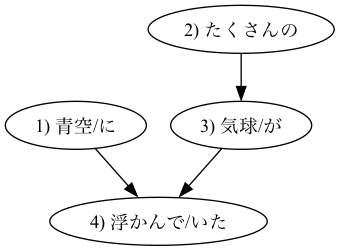

In [9]:
q = "青空にたくさんの気球が浮かんでいた"
response_body = post(q)
visualize_graphviz(response_body)

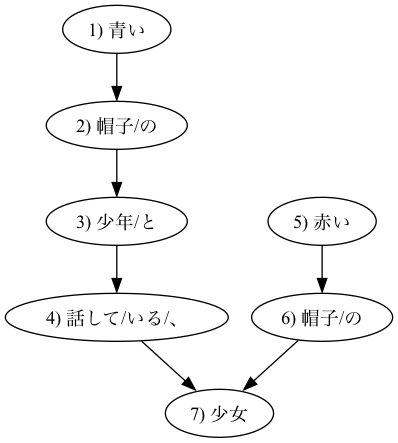

In [10]:
q = "青い帽子の少年と話している、赤い帽子の少女"
response_body = post(q)
visualize_graphviz(response_body)

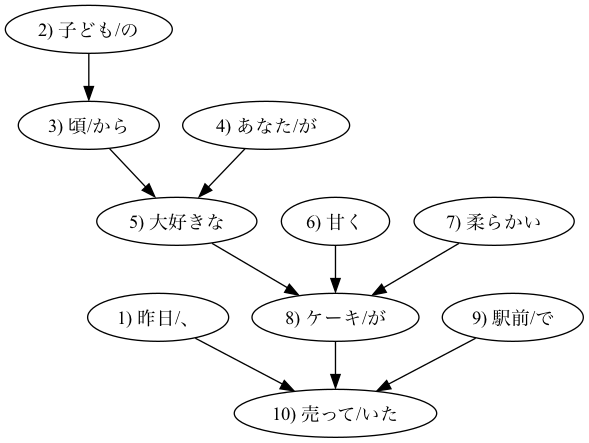

In [11]:
q = "昨日、子どもの頃からあなたが大好きな甘く柔らかいケーキが駅前で売っていた"
response_body = post(q)
visualize_graphviz(response_body)

### 参考情報
- https://spacy.io/usage/visualizers
- https://graphviz.readthedocs.io/

## 使用しているテキスト解析 Web API
- [日本語係り受け解析](../02_API_Specifications/05_DAService.md)

## 著者
LINEヤフー株式会社 言語処理エンジニア  
岩間 寛悟